## Regression Analysis on Best Model

In [2]:
"""
@author: Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
from optuna_train import *
debug_mode = True  # faster experiments for debugging

import pandas as pd
print(pd.__version__)
print(pd.__path__)
assert pd.__path__[0]!='/opt/anaconda/lib/python3.8/site-packages/pandas', 'Error! You are using deprecated python packages outside your conda environment. Did you use Jupyter Lab again?' 
# this is a nefarious problem with current version of anaconda, root cause is conda version install your own local one!
# lightly more superficial root cause is that you sometimes use jupyter lab which triggers you to use the /opt/anaconda/bin path backup when it sees jupyter lab isn't in local environment which breaks everything (uses outdated pandas)

2023-04-04 21:41:52.057783: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


1.5.1
['/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/pandas']


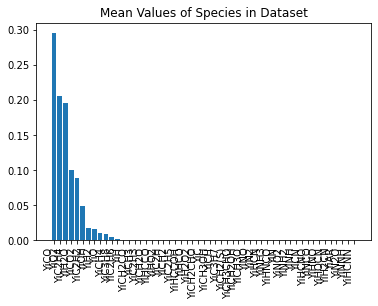

YiCO      0.295500
YiO2      0.205397
YiC2H4    0.195597
YiH2O     0.100139
YiCO2     0.088683
YiC2H2    0.048443
YiOH      0.017081
YiH2      0.016205
YiO       0.010780
YiCH4     0.009881
dtype: float64

['YiCO', 'YiO2', 'YiC2H4', 'YiH2O', 'YiCO2', 'YiC2H2', 'YiOH', 'YiH2', 'YiO', 'YiCH4']


In [35]:
BCs_only = False # turn on to only look at BCs!!

#Prepare the DataFrame that will be used downstream
dp = DataPreparer(fn='../datasets/wax_master.csv') # TODO: change me!
df = dp.getDataframe()

########################################
### Look for biggest Species Values! ###
mean_vals = df.filter(like='Yi').mean()
sort_idx = np.argsort(mean_vals)
mean_vals = mean_vals[sort_idx][::-1]
plt.bar(mean_vals.index, mean_vals)
plt.title('Mean Values of Species in Dataset')
plt.xticks(rotation=90, ha="right")
plt.show()
display(mean_vals[:10])
important_species = list(mean_vals[:10].index)
print(important_species)
########################################

if BCs_only:
    #df = df.sample(2)
    df=pd.concat([df.iloc[:1], df.iloc[-1:]],axis=0) # select boundary conditions!
    df.index=range(len(df))
    dp.df = df

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)
#dm.train_portion=0.5

In [36]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode
exprExec.setModelFactory(PCDNNV2ModelFactory())

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


In [37]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
emb_and_regressor = bestModel = bestModel.get_layer('emb_and_regression_model')
print(experimentSettings.keys())
print(experimentSettings['dataSetMethod'])
dm.createTrainTestData(experimentSettings['dataSetMethod'], experimentSettings['noOfCpv'], experimentSettings['ipscaler'], experimentSettings['opscaler'])

print(f'\nexperimentSettings: {str(experimentSettings)[:300]}...')
print(f'\nbestModel.input_shape: {bestModel.input_shape}')

dict_keys(['dataSetMethod', 'ipscaler', 'opscaler', 'noOfCpv', 'ZmixPresent', 'concatenateZmix', 'kernel_constraint', 'kernel_regularizer', 'activity_regularizer', 'input_data_cols', 'data_manager', 'val_losses', 'model_R2', 'history'])
AllSpecies_randomequaltraintestsplit_AllDependants
len testing df:  9331

experimentSettings: {'dataSetMethod': 'AllSpecies_randomequaltraintestsplit_AllDependants', 'ipscaler': None, 'opscaler': 'StandardScaler', 'noOfCpv': 10, 'ZmixPresent': 'Y', 'concatenateZmix': 'Y', 'kernel_constraint': 'Y', 'kernel_regularizer': 'Y', 'activity_regularizer': 'Y', 'input_data_cols': ['YiH2', 'YiH', 'YiO...

bestModel.input_shape: [(None, 53), (None, 1)]


[(None, 53), (None, 1)]
{'static_source_prediction': (None, 54), 'dynamic_source_prediction': (None, 10)}


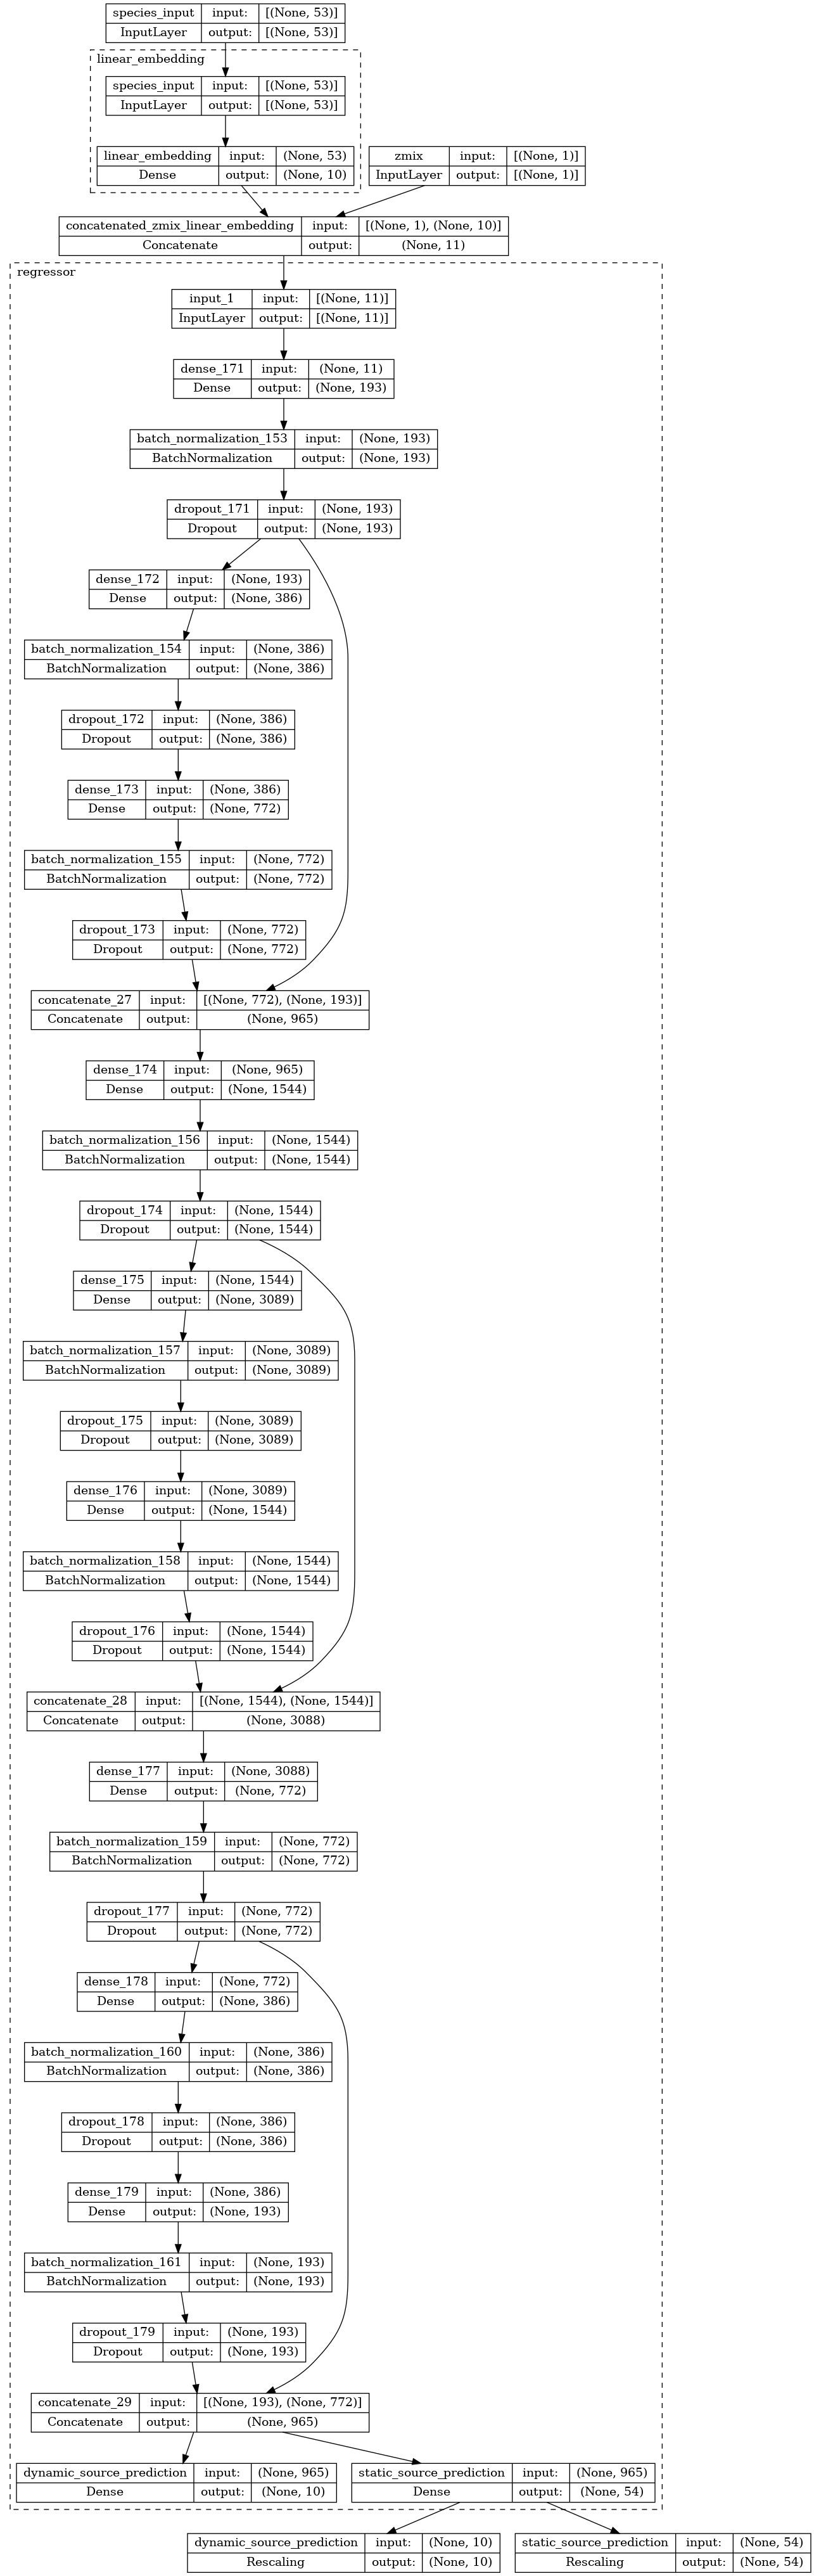

In [38]:
# simpler than reconstructing, but sanity is good...
linear_embedder = bestModel.get_layer('linear_embedding')
regressor = bestModel.get_layer('regressor')

print(bestModel.input_shape)
print(bestModel.output_shape)
tf.keras.utils.plot_model(bestModel, expand_nested=True, show_shapes=True)

## Manually Construct Data & Prepare Model:

In [39]:
X_train, X_test, Y_train, Y_test, zmix_train, zmix_test = dm.getTrainTestData()
source_train, source_test = dm.getSourceTrainTestData()

if BCs_only: # This is a hack to plot regression analysis for just the boundary cases
    X_test, Y_test, zmix_test, source_test = dm.getAllData()

In [40]:
CPV_train = linear_embedder({"species_input": np.asarray(X_train)})
true_dyn_train = linear_embedder({"species_input": np.asarray(source_train)})
true_dyn_test = linear_embedder({"species_input": np.asarray(source_test)})

In [41]:
input_dict_train = {"species_input": X_train, 'zmix': zmix_train}
input_dict_test = {"species_input": X_test, 'zmix': zmix_test}
output_dict_train = {'static_source_prediction': Y_train, 'dynamic_source_prediction': true_dyn_train}
output_dict_test = {'static_source_prediction': Y_test, 'dynamic_source_prediction': true_dyn_test}

In [42]:
from models import pcdnnv2_model_factory

@tf.function
def R2(yt,yp): return tf.reduce_mean(1-tf.reduce_mean((yp-yt)**2, axis=0)/tf.math.reduce_variance(yt,axis=0))

# for metric definitions see get_metric_dict()
metrics={'static_source_prediction': R2, 'dynamic_source_prediction': R2}
emb_and_regressor.compile(loss=None, optimizer='adam', metrics=metrics)

# Best Model Evaluation:
## R^2 Eval -- 
(**NOTE: requires max batch size or you get erroneous results!**)

In [43]:
# Verified to make "raw evaluation" (7/27/22) (as long as batch size is entire dataset!)
eval_ = emb_and_regressor.evaluate(input_dict_train, output_dict_train, batch_size=X_train.shape[0], return_dict=True, verbose=False)

# legacy compatibility
if 'regressor_R2' in eval_ or 'regressor_1_R2' in eval_:
    eval_['static_source_prediction_R2'] = eval_['regressor_R2']
    eval_['dynamic_source_prediction_R2'] = eval_['regressor_1_R2']
print(eval_)

print(f'Total loss: {eval_["loss"]}')
print(f'CPV_source_prediction R^2: {eval_["dynamic_source_prediction_R2"]}')
print(f'Static_deps_prediction R^2: {eval_["static_source_prediction_R2"]}')
print(f'Average R^2: {(eval_["dynamic_source_prediction_R2"]+eval_["static_source_prediction_R2"])/2}')

{'loss': 2.91353178024292, 'dynamic_source_prediction_R2': -0.020408641546964645, 'static_source_prediction_R2': -13.002283096313477}
Total loss: 2.91353178024292
CPV_source_prediction R^2: -0.020408641546964645
Static_deps_prediction R^2: -13.002283096313477
Average R^2: -6.511345868930221


## QQ regression plots:

['YiCH4', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiH2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN', 'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO', 'YiCN', 'YiHCN', 'YiH2CN', 'YiHCNN', 'YiHCNO', 'YiHOCN', 'YiHNCO', 'YiNCO', 'YiC3H7', 'YiC3H8', 'YiCH2CHO', 'YiCH3CHO', 'YiN2', 'YiAR']
292/292 [==============================] - 2s 5ms/step
mae 2.7921084011885324


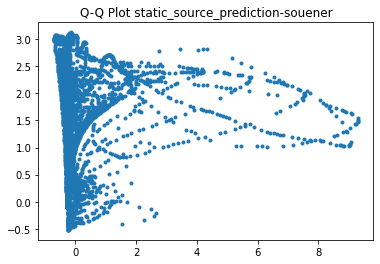

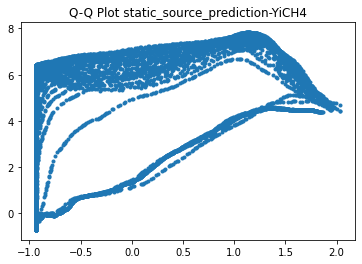

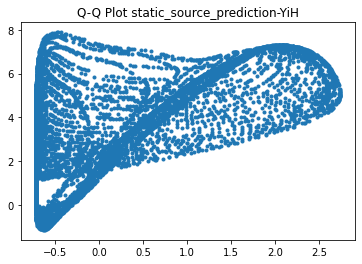

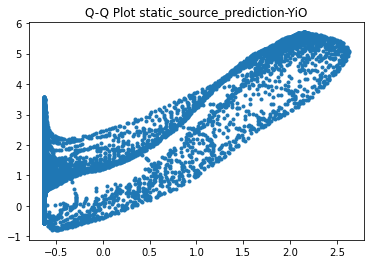

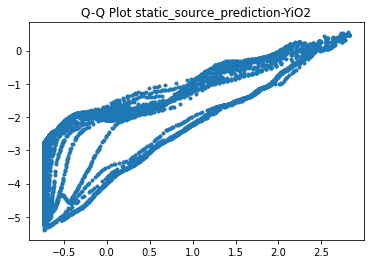

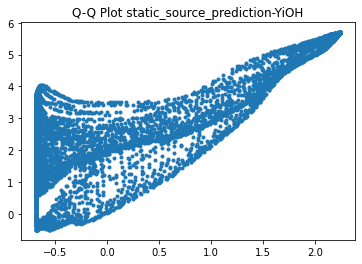

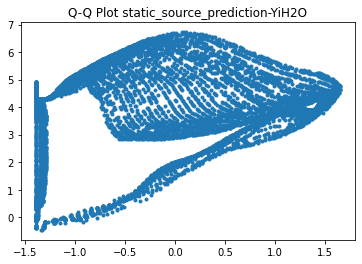

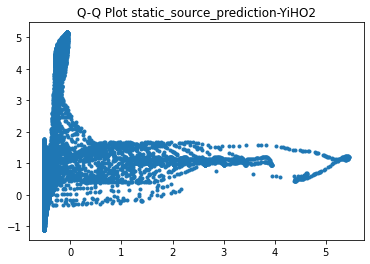

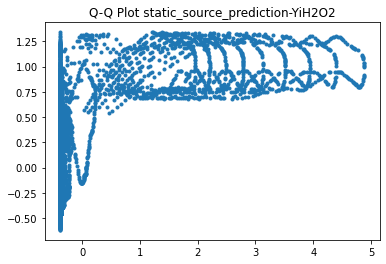

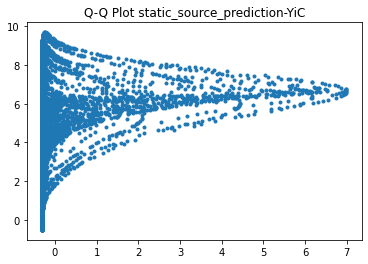

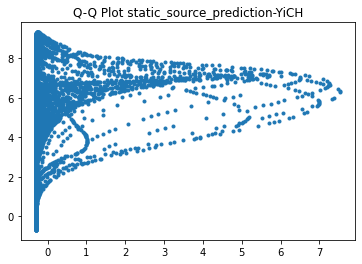

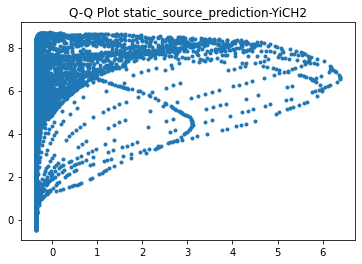

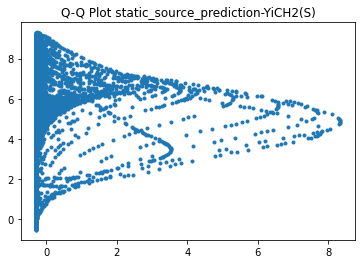

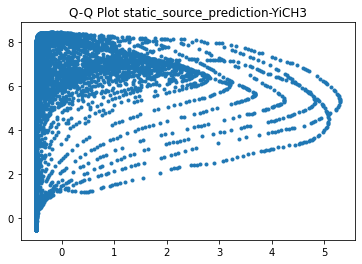

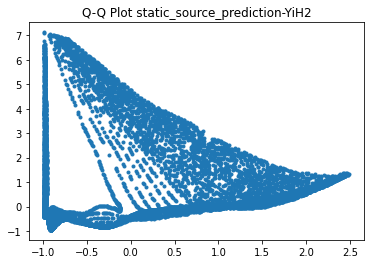

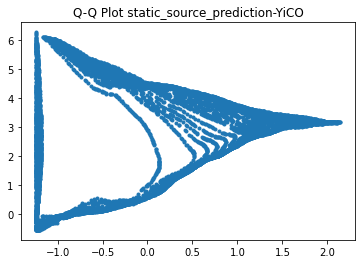

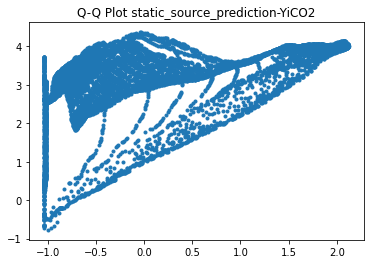

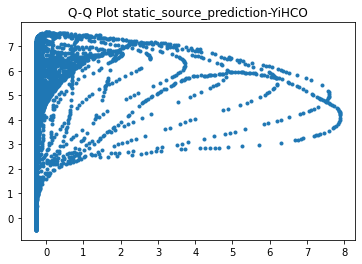

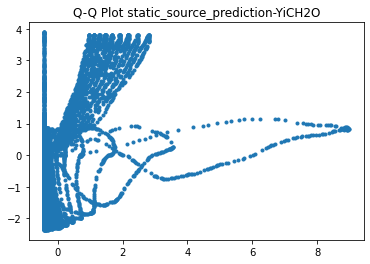

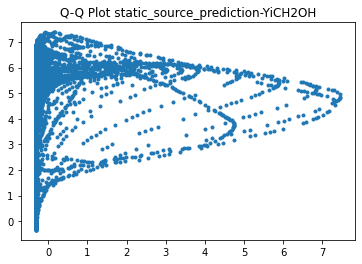

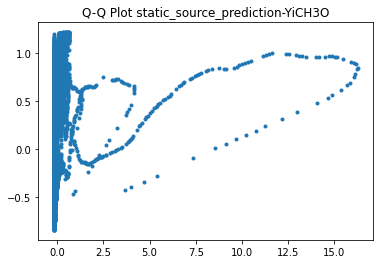

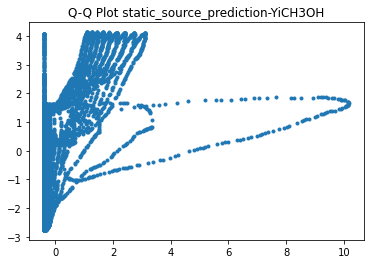

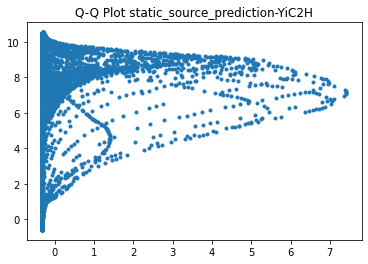

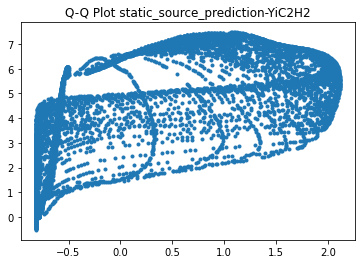

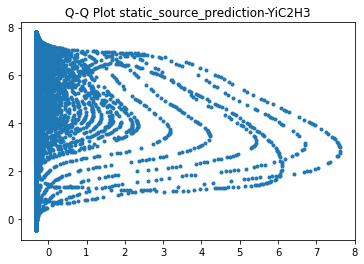

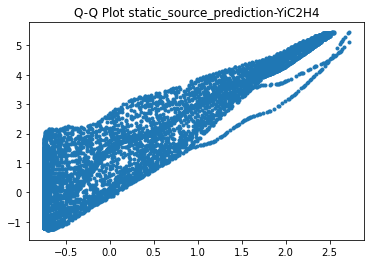

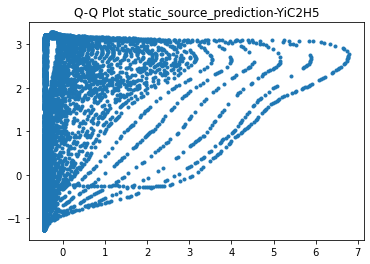

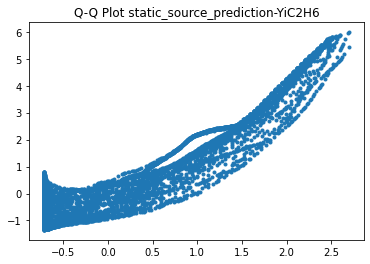

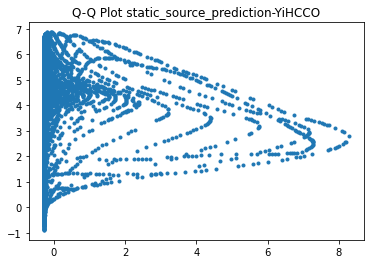

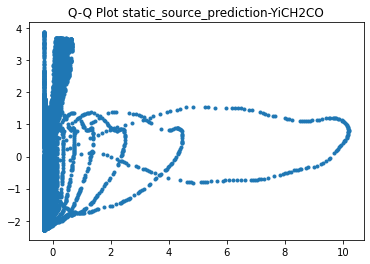

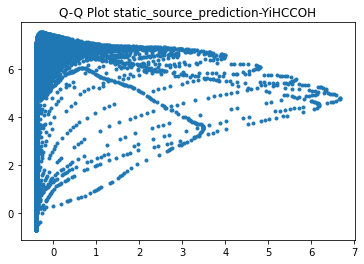

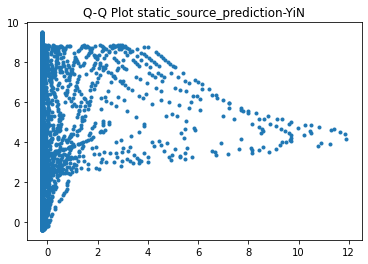

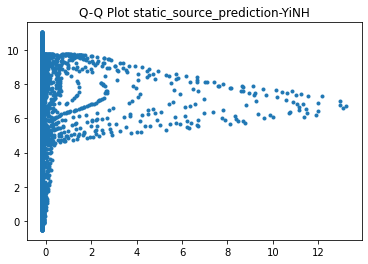

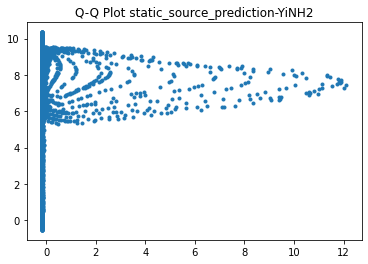

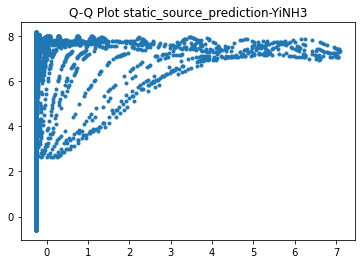

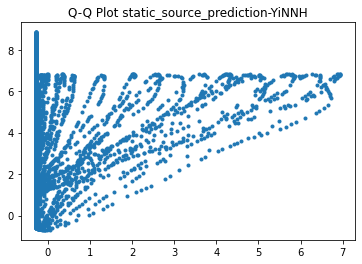

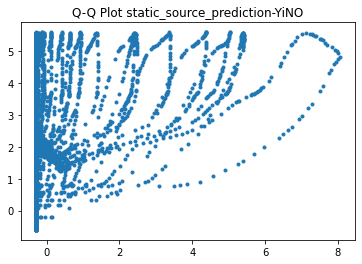

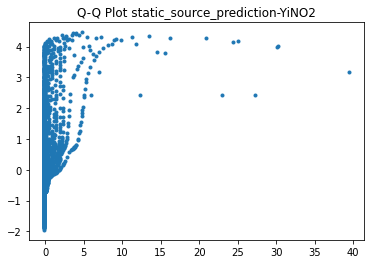

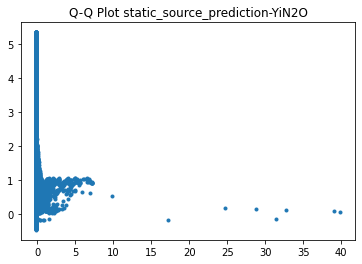

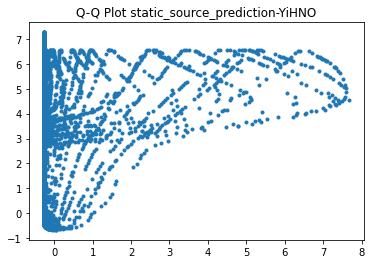

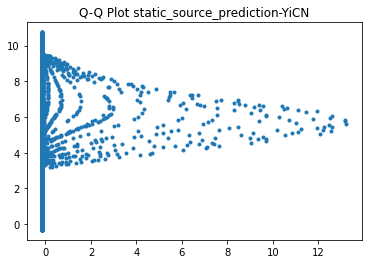

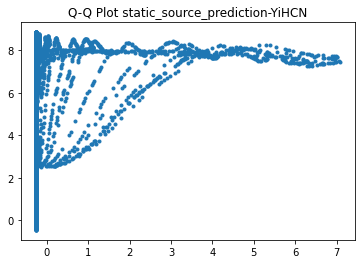

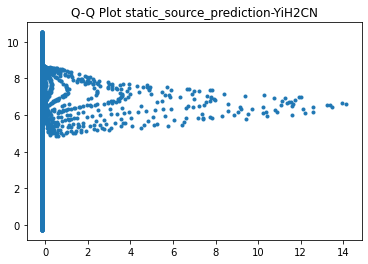

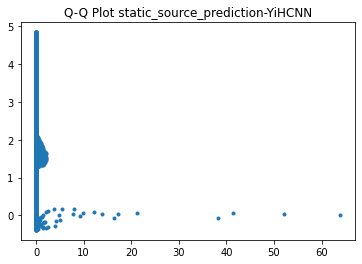

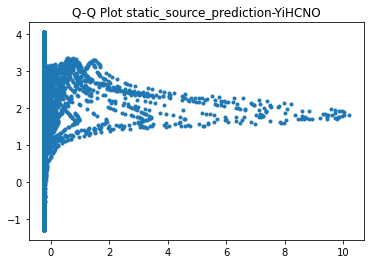

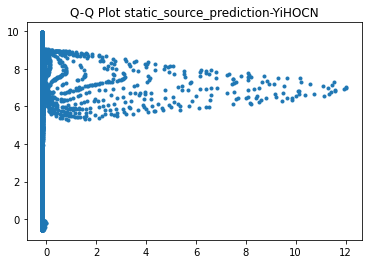

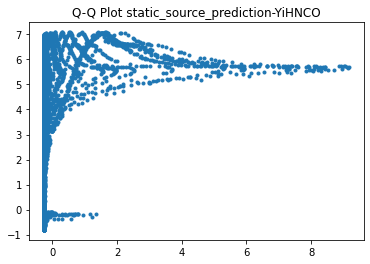

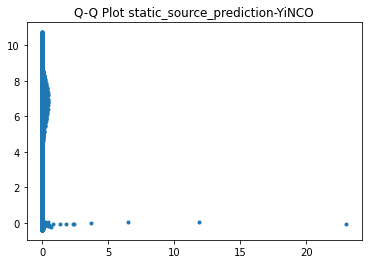

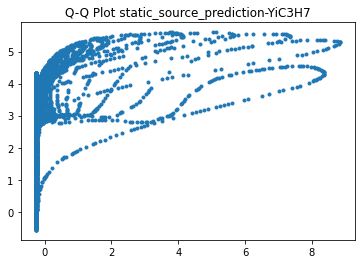

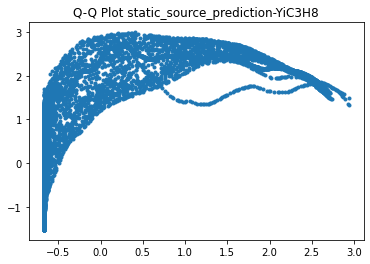

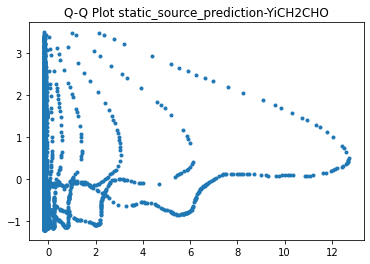

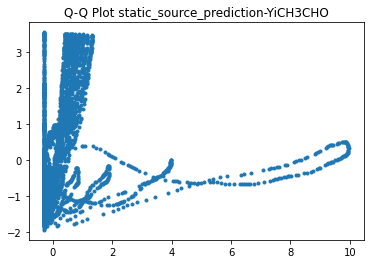

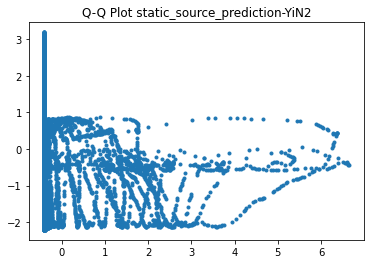

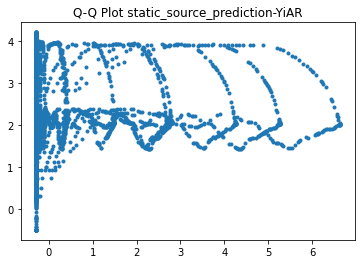

292/292 [==============================] - 1s 5ms/step
mae 125.00676


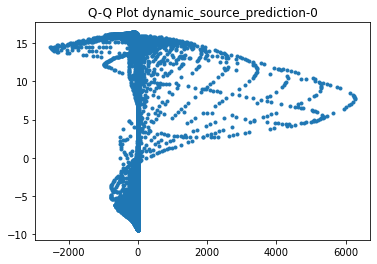

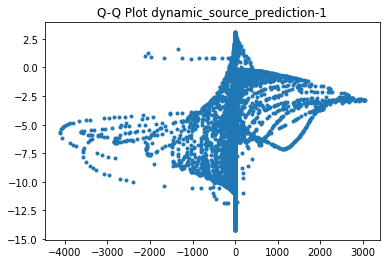

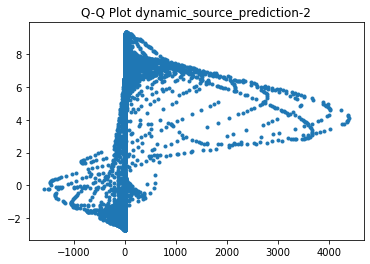

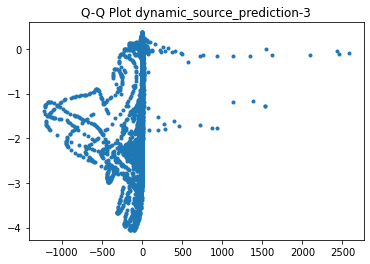

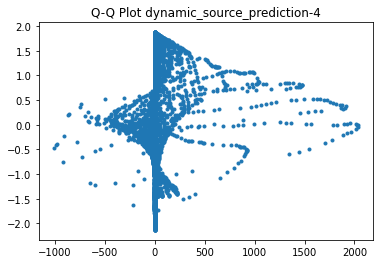

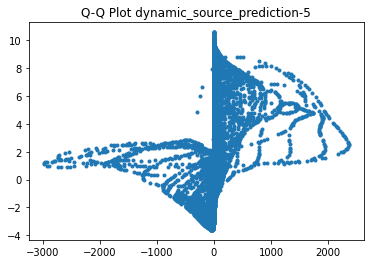

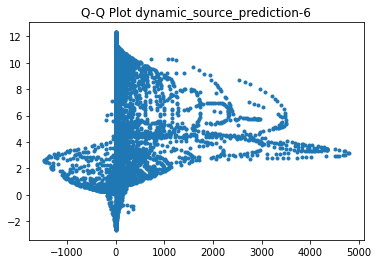

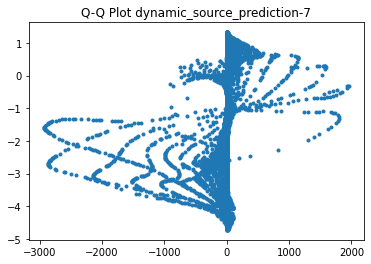

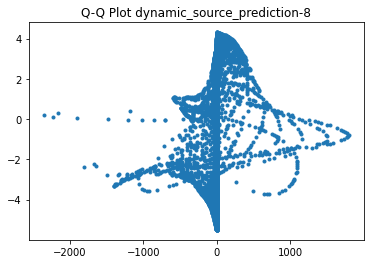

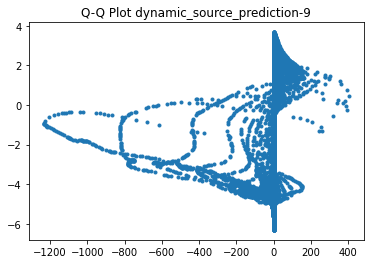

<tf.Tensor: shape=(9331, 10), dtype=float32, numpy=
array([[-3.27075691e+01, -4.87831543e+02, -4.22333679e+02, ...,
        -3.73795258e+02, -7.04006104e+02, -8.52942352e+01],
       [-7.55478573e+00,  1.89360321e+00, -4.80169153e+00, ...,
         3.93601513e+00, -1.63711286e+00,  3.65378881e+00],
       [-4.12024933e+02,  8.55508041e+00,  1.91555939e+01, ...,
        -1.62774750e+02, -2.46064262e+01, -1.00614204e+02],
       ...,
       [-5.89894819e+00,  8.67776299e+00, -3.75451827e+00, ...,
         2.14620614e+00,  2.32426906e+00,  1.92348492e+00],
       [-2.44674759e+01,  1.17543516e+01, -5.35706043e-01, ...,
        -8.64886189e+00,  6.29701614e-02, -1.00659037e+00],
       [-1.29627600e+01,  2.16696787e+00, -4.87619257e+00, ...,
         1.19245887e-01, -3.33751607e+00,  2.92353630e+00]], dtype=float32)>

In [26]:
import matplotlib.pyplot as plt

# QQ plots are good!!
#all_dependants = ["souener", "souspecO2", "souspecCO", "souspecCO2", "souspecH2O", "souspecOH", "souspecH2", "souspecCH4"]
all_dependants = ["souener"] + dm.input_data_cols
print(dm.input_data_cols)
def make_Error_plots(input_dict, output_dict, name, plot_residuals=False, names=None):
    preds = emb_and_regressor.predict(input_dict)
    if names is None: names = list(range(preds[name].shape[1]))
    
    residuals = output_dict[name]-preds[name]
    print('mae', np.mean(np.abs(residuals)))
    Y_vals = residuals if plot_residuals else preds[name]
    plt_name = 'Residual' if plot_residuals else 'Q-Q'
    
    for i in range(preds[name].shape[1]):
        plt.figure(i)
        plt.plot(output_dict[name][:, i], Y_vals[:,i], '.')
        plt.title(f'{plt_name} Plot {name}-{names[i]}')
        plt.show()
    return residuals
make_Error_plots(input_dict_test, output_dict_test, 'static_source_prediction', names=all_dependants, plot_residuals=False)
make_Error_plots(input_dict_test, output_dict_test, 'dynamic_source_prediction', plot_residuals=False)

## Compare Boundary Conditions Predictions to Real Values

292/292 [==============================] - 1s 3ms/step
test inputs: 


{'species_input': array([[8.35952519e-12, 3.70293560e-05, 1.59525077e-03, ...,
         6.20314173e-14, 2.97888229e-20, 0.00000000e+00],
        [3.01677927e-02, 4.63247806e-10, 2.89969579e-10, ...,
         2.36776998e-07, 2.92532627e-29, 0.00000000e+00],
        [1.25345805e-02, 2.11283253e-04, 1.59871135e-06, ...,
         9.13997063e-07, 4.97980485e-16, 0.00000000e+00],
        ...,
        [2.03613465e-02, 0.00000000e+00, 0.00000000e+00, ...,
         4.12440858e-11, 0.00000000e+00, 0.00000000e+00],
        [5.72654838e-03, 5.23629207e-04, 4.30389084e-06, ...,
         3.19483640e-08, 3.96472556e-11, 2.22044605e-16],
        [1.55394047e-02, 9.60104279e-06, 3.23401244e-10, ...,
         3.02478124e-08, 7.17903904e-08, 1.28264066e-12]]),
 'zmix': array([0.00527553, 0.96312008, 0.54153806, ..., 0.6278011 , 0.48134981,
        0.58011161])}

targets: 


,YiCO,YiO2,YiC2H4,YiH2O,YiCO2,YiC2H2,YiOH,YiH2,YiO,YiCH4
0,0.004989,9.778929e-01,1.646461e-13,0.005777,0.008638,1.529336e-11,6.731595e-04,4.463949e-05,1.595251e-03,8.359525e-12
1,0.038390,1.944944e-05,8.394741e-01,0.011722,0.006179,3.328241e-02,4.183555e-10,2.991098e-03,2.899696e-10,3.016779e-02
2,0.472230,5.599041e-04,7.583691e-02,0.147144,0.078244,1.708725e-01,1.998735e-04,3.492745e-02,1.598711e-06,1.253458e-02
3,0.346778,1.071192e-03,2.463007e-01,0.125063,0.070906,1.521719e-01,1.935509e-05,2.617849e-02,3.968137e-07,1.831033e-02
4,0.527314,1.405193e-04,3.978324e-02,0.141094,0.070466,1.658588e-01,2.093218e-04,3.893135e-02,8.167372e-07,1.081277e-02
...,...,...,...,...,...,...,...,...,...,...
9326,0.571599,1.278077e-04,1.288511e-02,0.146112,0.071915,1.436275e-01,5.567308e-04,3.988585e-02,4.483931e-06,7.623312e-03
9327,0.229975,1.387750e-06,5.471112e-01,0.044131,0.020294,9.132538e-02,1.651708e-09,1.894926e-02,4.670046e-12,2.587872e-02
9328,0.000000,3.494983e-01,5.910201e-01,0.000000,0.000000,1.238629e-02,0.000000e+00,1.730676e-08,0.000000e+00,2.036135e-02
9329,0.671073,5.902729e-06,1.645324e-03,0.111039,0.049718,1.096310e-01,4.130263e-04,4.749438e-02,4.303891e-06,5.726548e-03


preds: 


,YiCO,YiO2,YiC2H4,YiH2O,YiCO2,YiC2H2,YiOH,YiH2,YiO,YiCH4
0,0.236241,0.289546,0.136266,0.073343,0.059521,0.037684,0.011312,0.013128,0.004455,0.007880
1,1.730224,-1.254829,1.606507,0.417069,0.311334,0.401127,0.036975,0.127498,0.002264,0.058905
2,1.181034,-0.821647,0.110346,0.467281,0.406315,0.313283,0.090197,0.017675,0.052401,0.083181
3,1.257989,-1.058922,0.302555,0.542971,0.434212,0.339555,0.098766,0.023901,0.063443,0.086206
4,1.164222,-0.782222,0.205270,0.425007,0.393558,0.336745,0.077235,0.018690,0.044173,0.085588
...,...,...,...,...,...,...,...,...,...,...
9326,1.143032,-0.718872,0.202842,0.391600,0.378200,0.323667,0.073177,0.016867,0.038154,0.082512
9327,1.408562,-1.076596,1.133389,0.504511,0.390285,0.475825,0.040319,0.077257,0.026133,0.080969
9328,1.102565,-0.630591,1.110750,0.376047,0.363715,0.301235,0.040146,0.060204,0.027872,0.052415
9329,1.100738,-0.706375,0.458952,0.345615,0.320813,0.360584,0.050040,0.022602,0.021781,0.076365


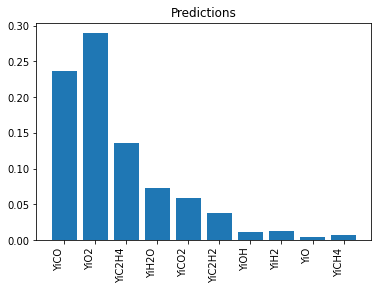

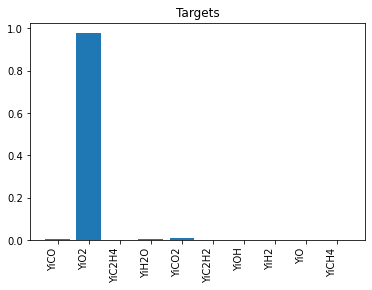

In [44]:
if BCs_only:
    preds = emb_and_regressor.predict(input_dict_test)
    preds = pd.DataFrame(dm.outputScaler.inverse_transform(preds['static_source_prediction'])[:,1:], columns=dm.input_data_cols)
    targets = pd.DataFrame(dm.outputScaler.inverse_transform(output_dict_test['static_source_prediction'])[:,1:], columns=dm.input_data_cols)
    preds = preds[important_species]
    targets = targets[important_species]

    print('test inputs: ')
    display(input_dict_test)
    print('targets: ')
    display(targets)
    print('preds: ')
    display(preds)

    plt.bar(preds.columns, preds.iloc[0])
    plt.xticks(rotation=90, ha="right")
    plt.title('Predictions')
    plt.show()

    plt.bar(preds.columns, targets.iloc[0])
    plt.xticks(rotation=90, ha="right")
    plt.title('Targets')
    plt.show()

## Residual Regression Plots:

292/292 [==============================] - 1s 5ms/step
mae 2.7921084011885324


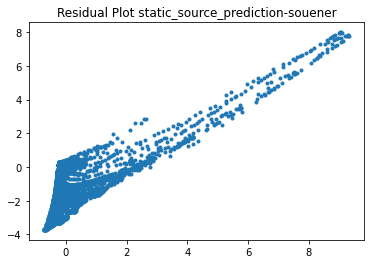

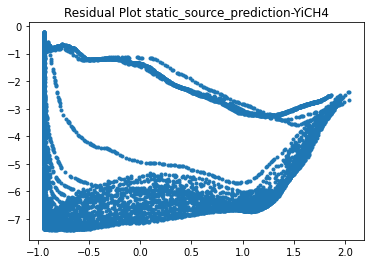

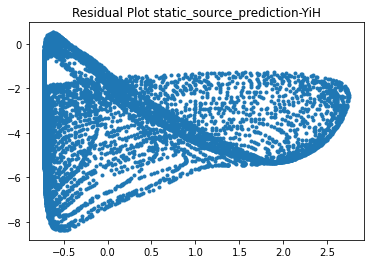

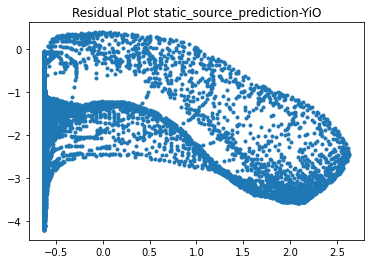

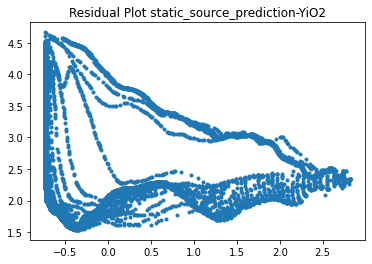

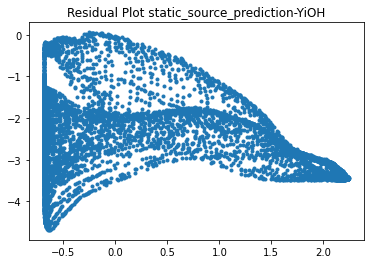

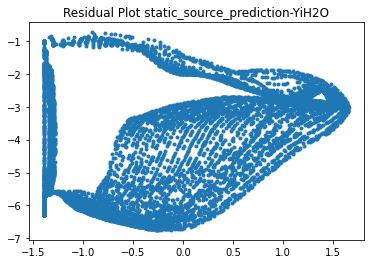

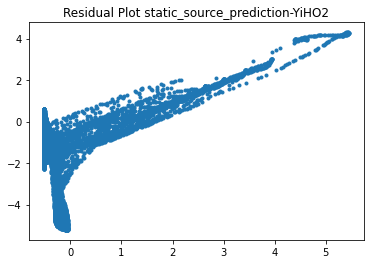

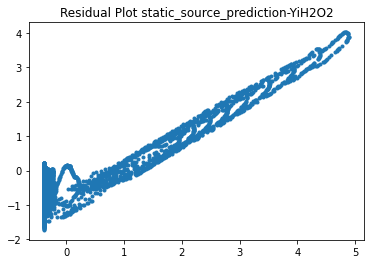

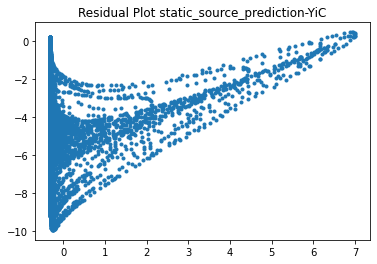

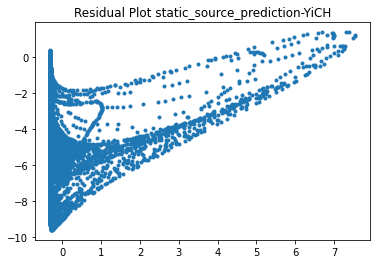

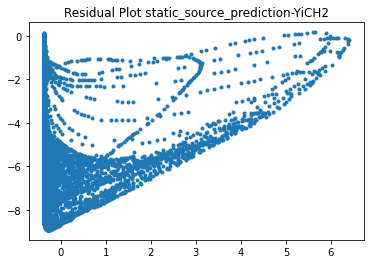

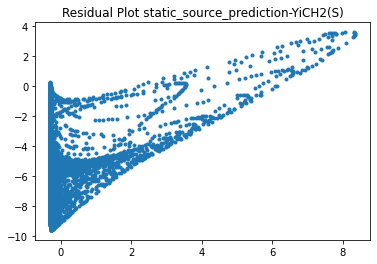

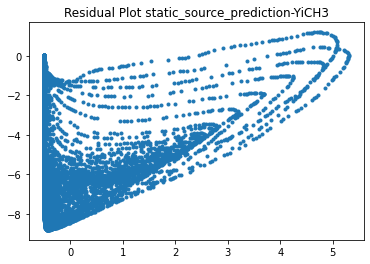

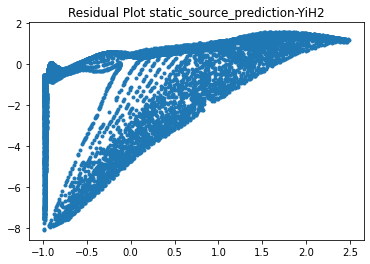

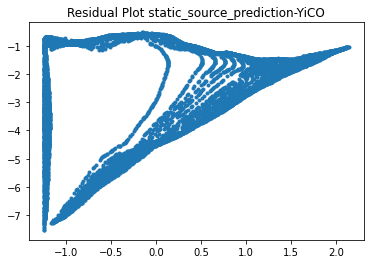

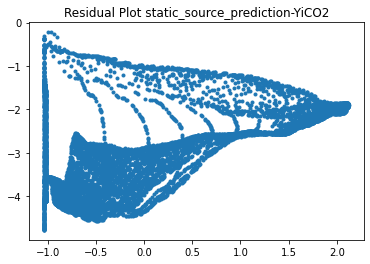

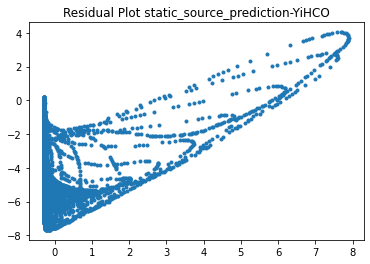

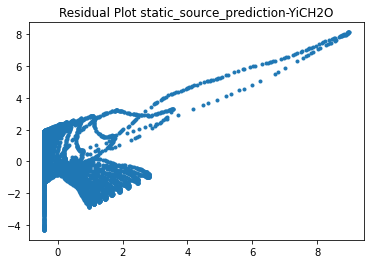

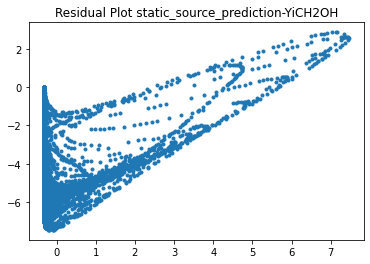

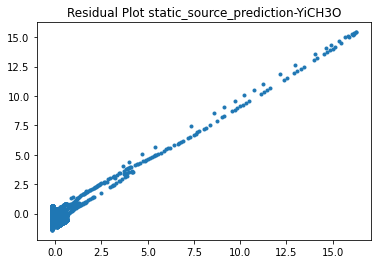

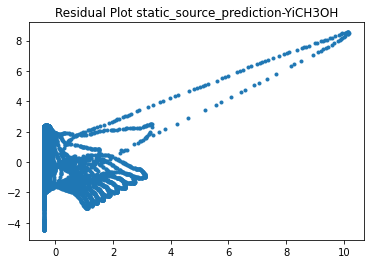

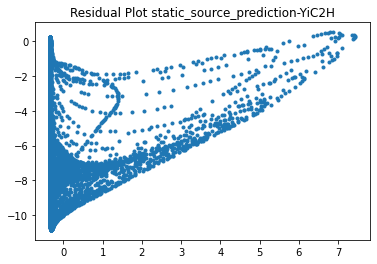

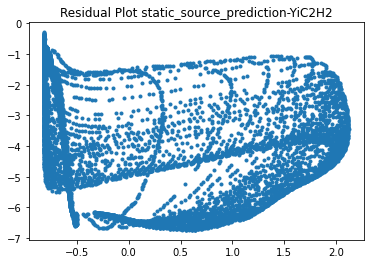

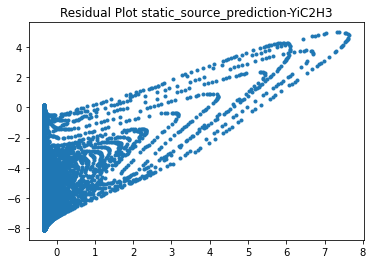

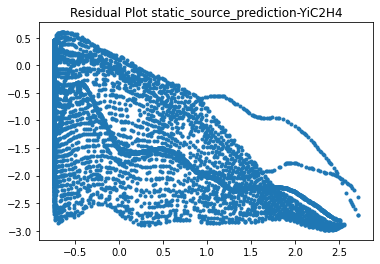

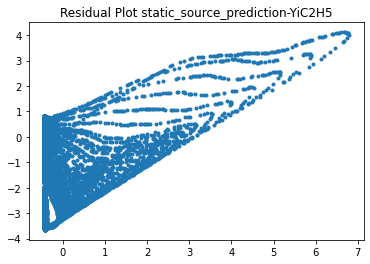

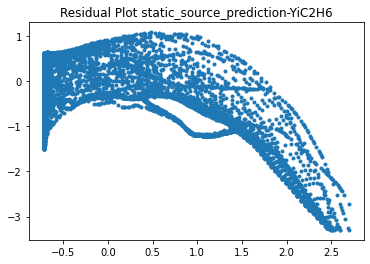

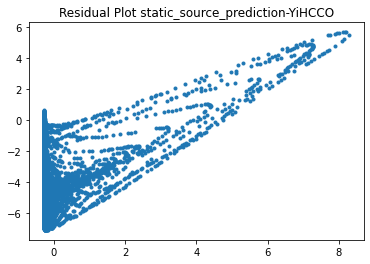

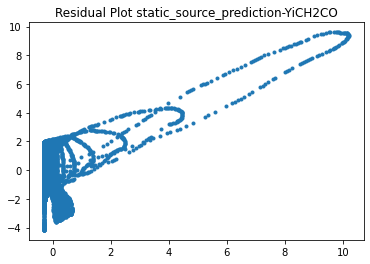

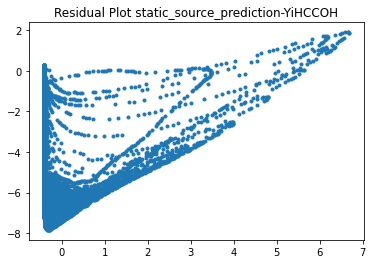

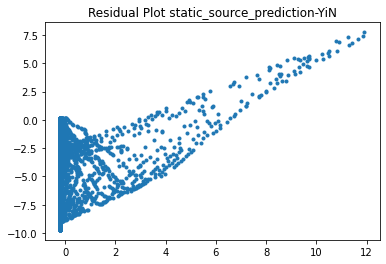

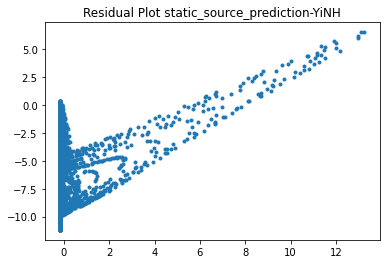

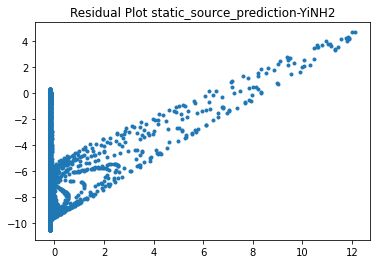

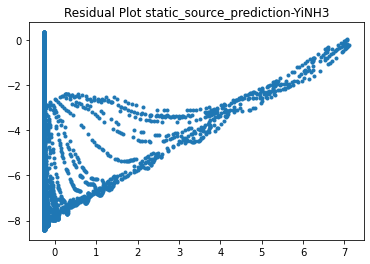

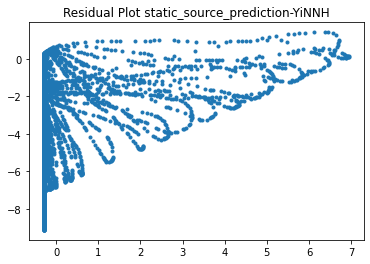

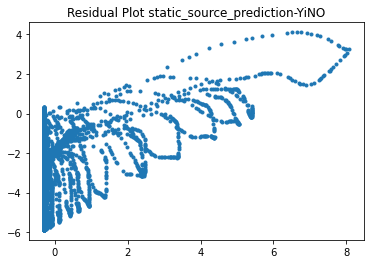

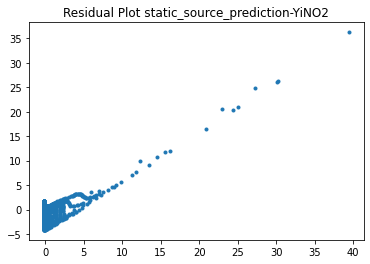

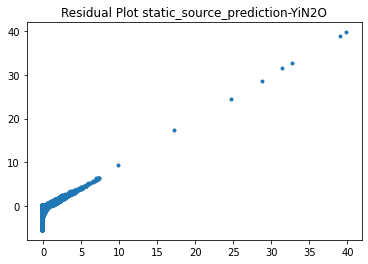

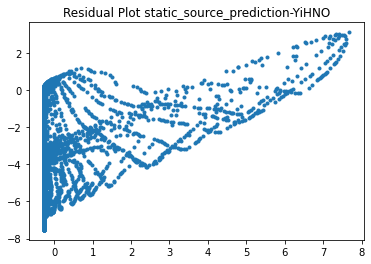

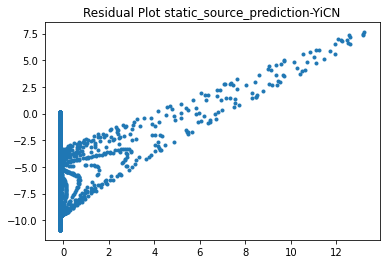

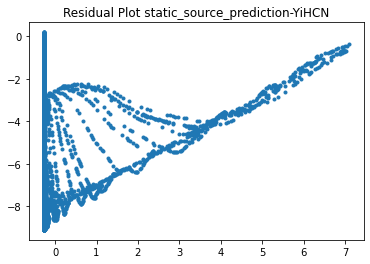

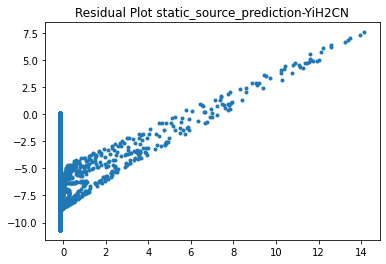

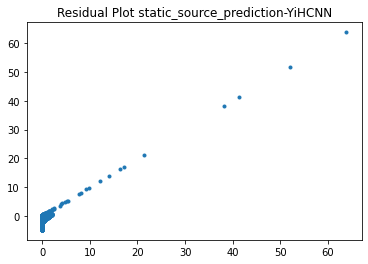

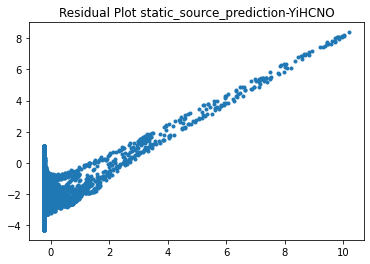

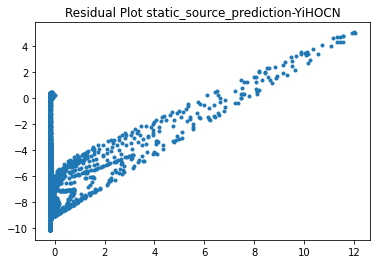

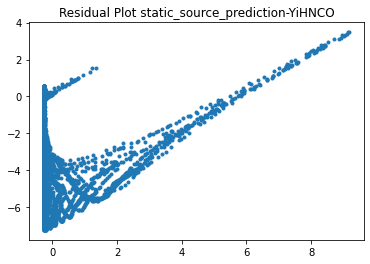

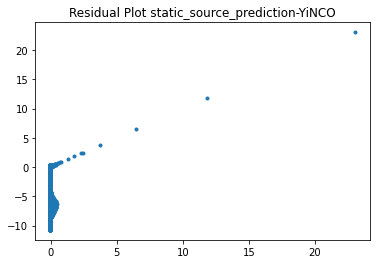

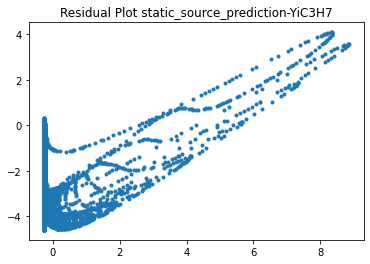

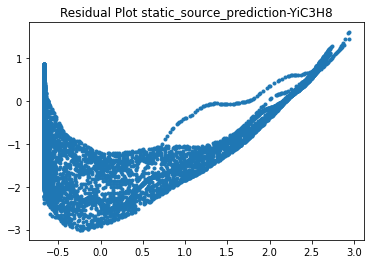

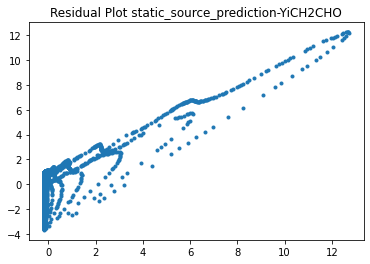

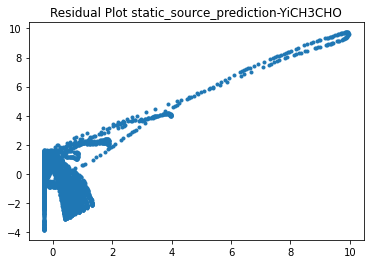

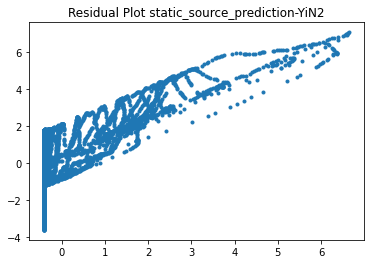

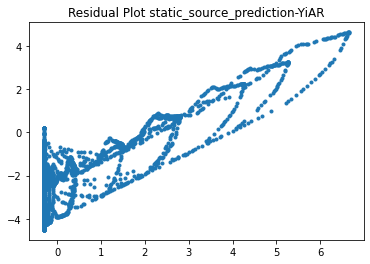

292/292 [==============================] - 1s 5ms/step
mae 125.00676


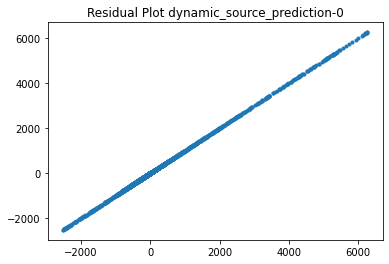

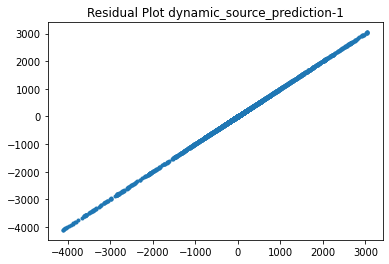

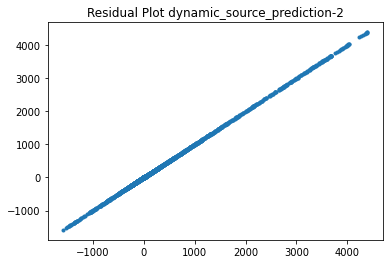

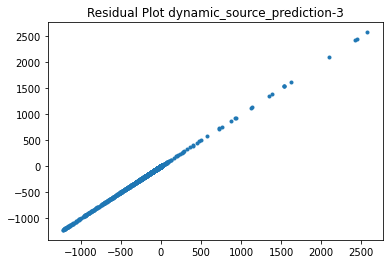

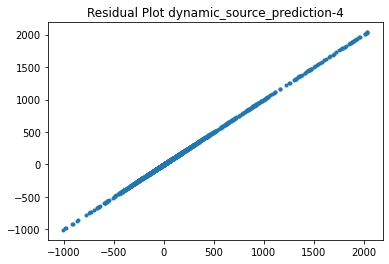

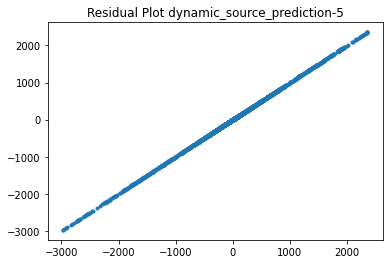

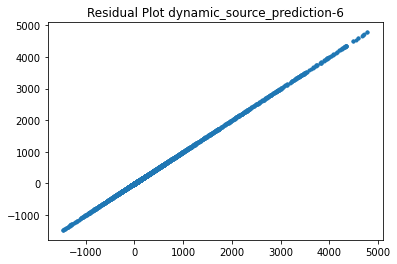

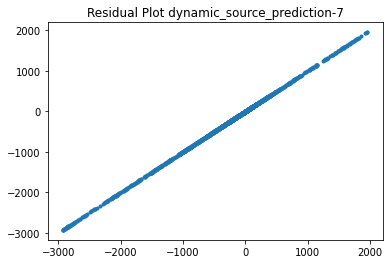

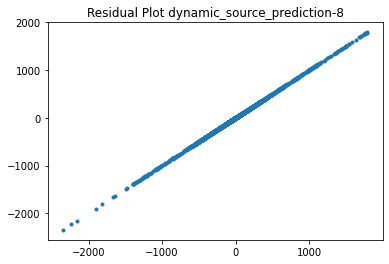

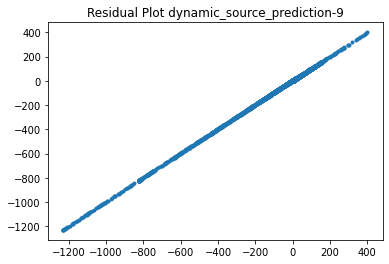

<tf.Tensor: shape=(9331, 10), dtype=float32, numpy=
array([[-3.27075691e+01, -4.87831543e+02, -4.22333679e+02, ...,
        -3.73795258e+02, -7.04006104e+02, -8.52942352e+01],
       [-7.55478573e+00,  1.89360321e+00, -4.80169153e+00, ...,
         3.93601513e+00, -1.63711286e+00,  3.65378881e+00],
       [-4.12024933e+02,  8.55508041e+00,  1.91555939e+01, ...,
        -1.62774750e+02, -2.46064262e+01, -1.00614204e+02],
       ...,
       [-5.89894819e+00,  8.67776299e+00, -3.75451827e+00, ...,
         2.14620614e+00,  2.32426906e+00,  1.92348492e+00],
       [-2.44674759e+01,  1.17543516e+01, -5.35706043e-01, ...,
        -8.64886189e+00,  6.29701614e-02, -1.00659037e+00],
       [-1.29627600e+01,  2.16696787e+00, -4.87619257e+00, ...,
         1.19245887e-01, -3.33751607e+00,  2.92353630e+00]], dtype=float32)>

In [46]:
make_Error_plots(input_dict_test, output_dict_test, 'static_source_prediction', names=all_dependants, plot_residuals=True)
make_Error_plots(input_dict_test, output_dict_test, 'dynamic_source_prediction', plot_residuals=True)

### CPV Distribution Plots (its Weird!):

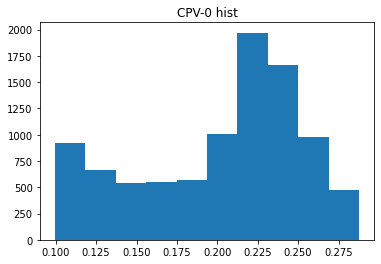

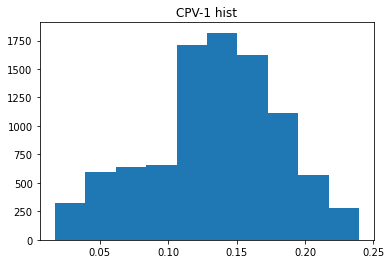

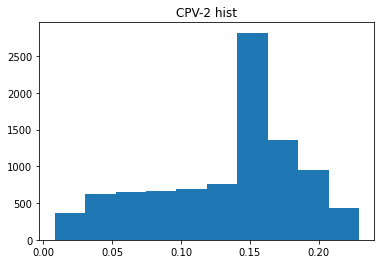

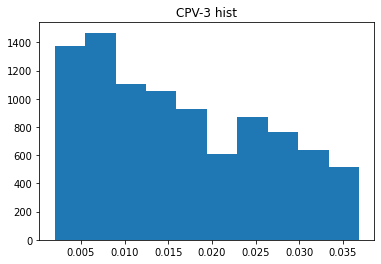

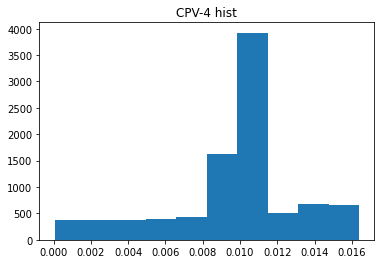

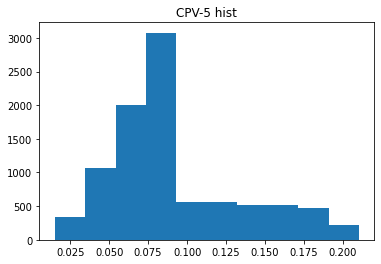

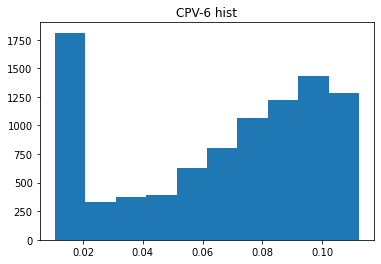

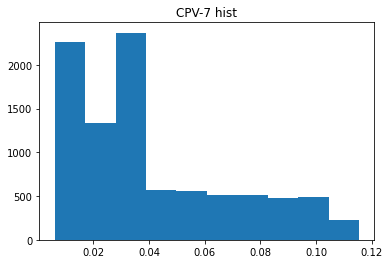

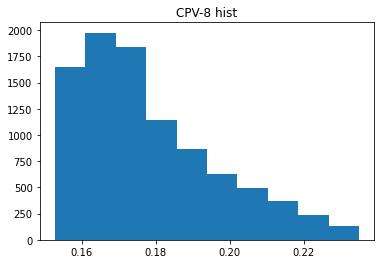

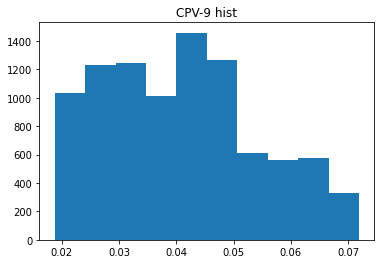

In [47]:
for i in range(CPV_train.shape[1]):
    plt.figure(i)
    plt.hist(CPV_train[:,i].numpy().squeeze())
    plt.title(f'CPV-{i} hist')
    plt.show()

In [48]:
# Sanity check on names!
def sanity_check_names(): # function to prevent namespace pollution
    input_dict_train, input_dict_test, output_dict_train, output_dict_test = exprExec.prepare_model_data_dicts(dm=dm)
    X_train_cols = dm.df_testing[dm.input_data_cols].columns
    source_train_cols = source_train.columns

    # check that order of source-terms matches order of species
    assert all(np.array([col[2:] for col in X_train_cols]) == np.array([col[7:] for col in source_train_cols]))
sanity_check_names()